In [102]:
import numpy as np
from vivarium import Vivarium
from spatio_flux import PROCESS_DICT, TYPES_DICT, build_path

In [103]:
# TODO -- make a spatio-flux specific Vivarium with the the core preloaded
v = Vivarium(processes=PROCESS_DICT, types=TYPES_DICT)

In [104]:
v.get_types()

,Type
0,
1,reaction
2,current*time^2/length^2*mass
3,printing_unit
4,array
...,...
97,length*temperature
98,length^2
99,length^0_5*mass^0_5
100,length^2/time^2


In [105]:
# view the available processes
v.get_processes()

,Process
0,composite
1,DiffusionAdvection
2,DynamicFBA
3,Particles
4,console-emitter
5,json-emitter
6,ram-emitter
7,MinimalParticle


## dFBA alone

In [106]:
# inspect the config schema for the 'increase' process
v.process_schema('DynamicFBA')

'(model_file:string|kinetic_params:map[tuple[float,float]]|substrate_update_reactions:map[string]|biomass_identifier:string|bounds:map[bounds])'

In [107]:
# TODO - enable get_dataclass to work with the new process
# dfba_config  = v.get_dataclass('DynamicFBA')
dfba_config = {
    "model_file": "textbook",
    "kinetic_params": {
        "glucose": (0.5, 1),
        "acetate": (0.5, 2)},
    "substrate_update_reactions": {
        "glucose": "EX_glc__D_e",
        "acetate": "EX_ac_e"},
    "biomass_identifier": "biomass",
    "bounds": {
        "EX_o2_e": {"lower": -2, "upper": None},
        "ATPM": {"lower": 1, "upper": 1}
    }
}

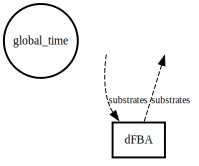

In [108]:
# add a dynamic FBA process called 'dFBA'
v.add_process(name="dFBA",
              process_id="DynamicFBA",
              config=dfba_config,
              )
v.diagram(dpi='70')

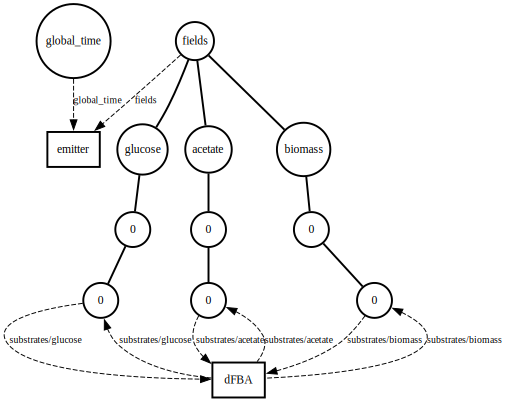

In [109]:
mol_ids = ["glucose", "acetate", "biomass"]
path=["fields"]
i = 0
j = 0

# for mol_id in mol_ids:
#     v.add_object(
#         name=mol_id,
#         path=path,
#         # type='array',
#         value=np.random.rand()
#     )

v.connect_process(
    process_name="dFBA",
    inputs={
            "substrates": {
                mol_id: build_path(mol_id, path, i, j)
                for mol_id in mol_ids}
        },
    outputs={
            "substrates": {
                mol_id: build_path(mol_id, path, i, j)
                for mol_id in mol_ids}
        }
)

# add an emitter to save results
v.add_emitter()

# TODO -- show_values does not work
v.diagram(dpi='70', show_values=True)

In [110]:
v.set_value(path = ['fields', 'glucose', 0, 0], value=10)
v.set_value(path = ['fields', 'biomass', 0, 0], value=0.1)
field = v.get_value(['fields'])
print(field)

{'glucose': {0: {0: 10}}, 'acetate': {0: {0: 0.0}}, 'biomass': {0: {0: 0.1}}}


In [111]:
# run the simulation for 10 time units
v.run(interval=60)

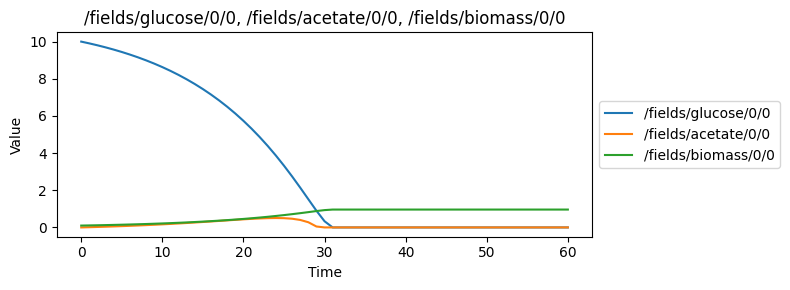

In [112]:
v.plot_timeseries(
    subplot_size=(8, 3),
    combined_vars=[
        [
            '/fields/glucose/0/0',
            '/fields/acetate/0/0',
            '/fields/biomass/0/0'
        ]
    ]
)

## Spatial Dynamic FBA

Adding dFBA[0,0] to ['fields', 'mol_id', 0, 0]



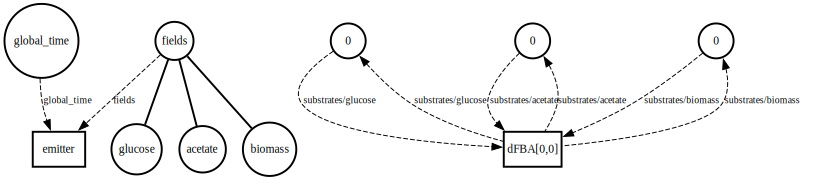

In [119]:
mol_ids = ["glucose", "acetate", "biomass"]
path=["fields"]
rows = 1
columns = 1

# make the vivarium
v2 = Vivarium(processes=PROCESS_DICT, types=TYPES_DICT)
for mol_id in mol_ids:
    v2.add_object(
        name=mol_id,
        path=path,
        # type='array',
        value=np.random.rand(rows, columns)
    )

# add a dynamic FBA process at every location
for i in range(rows):
    for j in range(columns):
        dfba_name = f"dFBA[{i},{j}]"
        path_name = build_path('mol_id', path, i, j)
        print(f'Adding {dfba_name} to {path_name}\n')

        rewire_path= path  # [".."] + path

        # add a process for this location
        v2.add_process(
            name=dfba_name,
            process_id="DynamicFBA",
            # path=['species'],
            config=dfba_config,
        )
        v2.connect_process(
            process_name=dfba_name,
            # path=['species'],
            inputs={
                    "substrates": {
                        mol_id: build_path(mol_id, rewire_path, i, j)
                        for mol_id in mol_ids}
                },
            outputs={
                    "substrates": {
                        mol_id: build_path(mol_id, rewire_path, i, j)
                        for mol_id in mol_ids}
                }
        )

# add an emitter to save results
v2.add_emitter()

v2.diagram(dpi='70')

In [114]:
v2.run(20)

In [115]:
timeseries = v2.get_timeseries()

In [116]:
timeseries

,/global_time,/fields/glucose,/fields/acetate,/fields/biomass
0,0.0,[[0.48725581278884245]],[[0.1833352950628817]],[[0.6143349082997999]]
1,1.0,[[0.18405349056336529]],[[0.0]],[[0.6465536028301284]]
2,2.0,[[0.010089832634802148]],[[0.0]],[[0.6592073723003393]]
3,3.0,[[0.010089832634802148]],[[0.0]],[[0.6592073723003393]]
4,4.0,[[0.010089832634802148]],[[0.0]],[[0.6592073723003393]]
5,5.0,[[0.010089832634802148]],[[0.0]],[[0.6592073723003393]]
6,6.0,[[0.010089832634802148]],[[0.0]],[[0.6592073723003393]]
7,7.0,[[0.010089832634802148]],[[0.0]],[[0.6592073723003393]]
8,8.0,[[0.010089832634802148]],[[0.0]],[[0.6592073723003393]]
9,9.0,[[0.010089832634802148]],[[0.0]],[[0.6592073723003393]]


KeyError: '/fields/glucose/0/0'

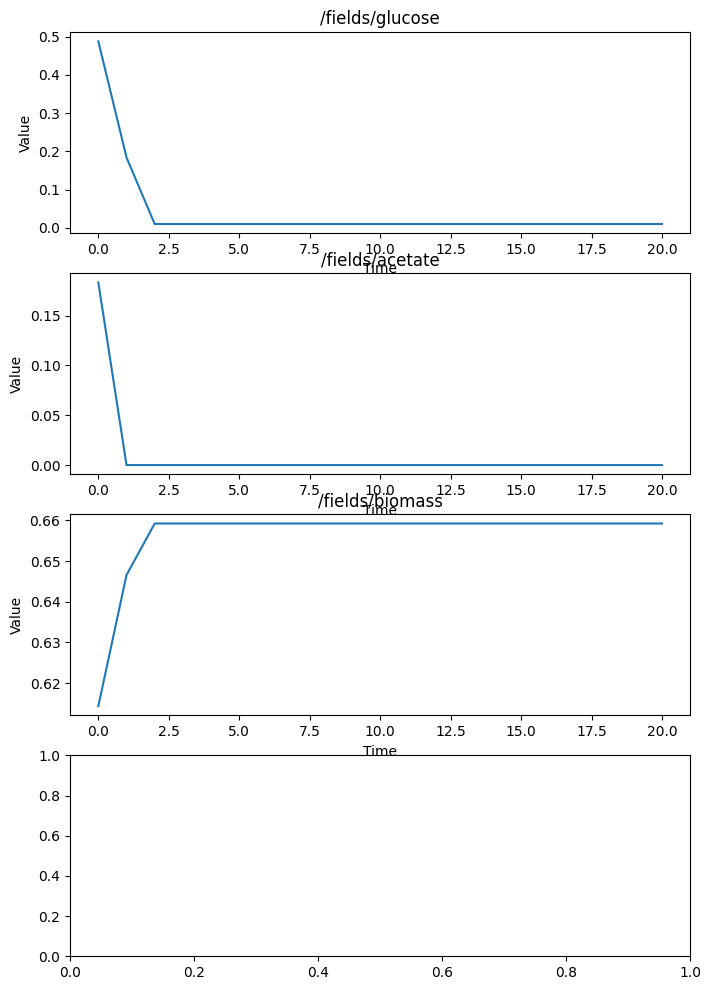

In [117]:
v2.plot_timeseries(
    subplot_size=(8, 3),
    combined_vars=[
        [
            '/fields/glucose/0/0',
            '/fields/acetate/0/0',
            '/fields/biomass/0/0'
        ]
    ]
)